# Контекст

- предсказать тему текста на русском языке
- 13 классов
- Колличесвто образцов = 38740

In [1]:
import pandas as pd
import numpy as np
import json


from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset,\
                             DataLoader

from sklearn.metrics import f1_score
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
warnings.filterwarnings("ignore")
print('CUDA ?: ', torch.cuda.is_available())

CUDA ?:  True


# Чтение

In [2]:
train = pd.read_csv('train.csv')
train = train[['category','text']]
train.head()

,category,text
0,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...


In [3]:
len(train)

38740

In [4]:
train['category'].value_counts()

category
autosport       3160
extreme         3110
martial_arts    3050
motosport       3030
boardgames      3020
tennis          3000
esport          2990
athletics       2970
hockey          2950
volleyball      2950
football        2860
basketball      2850
winter_sport    2800
Name: count, dtype: int64

In [3]:
category2label = dict(zip(train['category'].unique(), np.arange(0, len(train['category'].unique()))))
label2category = {label: category for category, label in category2label.items()}
category2label

{'winter_sport': 0,
 'extreme': 1,
 'football': 2,
 'boardgames': 3,
 'hockey': 4,
 'esport': 5,
 'athletics': 6,
 'motosport': 7,
 'basketball': 8,
 'tennis': 9,
 'autosport': 10,
 'martial_arts': 11,
 'volleyball': 12}

In [4]:
train['category'] = train['category'].map(category2label)
train.head()

,category,text
0,0,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,1,Возвращение в подземелье Треша 33 Эйфория тупо...
2,2,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,3,Rtokenoid Warhammer40k валрак решил нас подкор...
4,4,Шестеркин затаскивает Рейнджерс в финал Восточ...


# Скачивание модели и токенизатора

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizerFast

model_name = "rubert-tiny"
num_classes = 13

tokenizer = AutoTokenizer.from_pretrained("seara/rubert-tiny2-ru-go-emotions")
# tokenizer = BertTokenizerFast.from_pretrained('DeepPavlov/rubert-base-cased', max_length = 512)
model = AutoModelForSequenceClassification.from_pretrained("seara/rubert-tiny2-ru-go-emotions")

In [7]:
model = AutoModelForSequenceClassification.from_pretrained("seara/rubert-tiny2-ru-go-emotions")
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, 

In [10]:
label2category

{0: 'winter_sport',
 1: 'extreme',
 2: 'football',
 3: 'boardgames',
 4: 'hockey',
 5: 'esport',
 6: 'athletics',
 7: 'motosport',
 8: 'basketball',
 9: 'tennis',
 10: 'autosport',
 11: 'martial_arts',
 12: 'volleyball'}

In [8]:
config = model.config
config.num_labels = len(train['category'].unique())
config

BertConfig {
  "_name_or_path": "seara/rubert-tiny2-ru-go-emotions",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "emb_size": 312,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 312,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 600,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 2048,
  "mo

In [9]:
model = AutoModelForSequenceClassification.from_config(config)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, 

# train-val-test

In [5]:
train, test = train_test_split(
    train,
    test_size = 0.1,
    random_state = 42,
    stratify = train['category']
)

train, val = train_test_split(
    train,
    test_size = 0.3,
    random_state = 42,
    stratify = train['category']
)

print(len(train), len(val), len(test))

24406 10460 3874


# Dataset - Dataloader

In [6]:
class RuSportTopicsDataset(Dataset):
    def __init__(self, tokenizer, df, max_len = 512):

        self.tokenizer = tokenizer
        self.data = df
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):

        text = self.data.iloc[idx]['text']
        encoding = self.tokenizer.encode_plus(
                text,
                add_special_tokens = True,
                max_length = self.max_len,
                truncation=True,
                return_token_type_ids = False,
                padding = 'max_length',
                return_attention_mask = True,
                return_tensors = 'pt'      
        )
        
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        labels = self.data.iloc[idx]['category']

        return {
            'text': text,
            'input_ids': torch.tensor(input_ids).flatten(),
            'attention_mask': torch.tensor(attention_mask).flatten(),
            'labels': torch.tensor(labels, dtype = torch.long)
        }

In [24]:
train_dataset = RuSportTopicsDataset(tokenizer, train)
val_dataset = RuSportTopicsDataset(tokenizer, val)

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    drop_last = True,
    shuffle = False
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = 32,
    drop_last = True,
    shuffle = False
)

# Проверка Dataloader

In [25]:
for batch in train_dataloader:
    batch = batch
    break

In [26]:
batch.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'labels'])

In [27]:
input_ids = batch['input_ids']
attention_mask = batch['attention_mask']
labels = batch['labels']

In [28]:
input_ids.shape

torch.Size([32, 512])

In [29]:
attention_mask.shape

torch.Size([32, 512])

In [30]:
labels

tensor([10,  9,  0, 12, 10, 12,  6,  8,  3, 12,  0, 12,  5, 11, 12, 12, 12, 12,
         0, 11,  1,  6,  5,  5, 11,  2, 11,  8,  3,  0,  4, 12])

In [31]:
model.eval()
model = model.cpu()
outputs = model(input_ids, attention_mask)[0]

In [32]:
outputs.shape

torch.Size([32, 13])

In [33]:
loss_function = nn.CrossEntropyLoss()
loss = loss_function(outputs, labels)
loss

tensor(2.5556, grad_fn=<NllLossBackward0>)

In [34]:
loss.item()

2.555635929107666

# metrics / regulizer

In [7]:
def loss_with_l1_or_l2_regulizer(
        
        model,
        type, # Здесь могут быть 3 вида : 'l1', 'l2', 'l1_l2' 
        l_lambda, # 0.001
        loss_by_fn):
    
    if type == 'l2':
        l_norm = sum(p.pow(2.0).sum() for p in model.parameters())

    if type == 'l1':
        l_norm = sum(p.abs().sum() for p in model.parameters())

    if type == 'l1_l2':
        l_norm = sum((p.abs() + p.pow(2.0)).sum() for p in model.parameters())
    
    loss_plus_reg = loss_by_fn + l_lambda * l_norm
    return loss_plus_reg



def create_folder(name):
    import os
    os.mkdir(name)


from sklearn.metrics import (accuracy_score, precision_recall_fscore_support)

def compute_metrics(output, y_true):

    y_true = y_true.detach().cpu().numpy()
    y_pred = torch.argmax(output, dim = 1).detach().cpu().numpy()
    Precision, Recall, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average = 'macro'
    )
    acc = accuracy_score(y_true, y_pred)
    
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': Precision,
        'Recall': Recall
    }

# training loop

In [8]:
def training_loop(
        # папка сохранения
        name_model_folder,
        # основные настройки
        epoches,
        model,
        optimizer,
        loss_fn,
        train_dataloader,
        val_dataloader,
        # regulizer
        regulizer_append,
        reg_type,
        # stop mode
        partience,
        # verbose
        verbose_epoch
        ):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    create_folder(name_model_folder)

    batch_data = {
           'epoch_number':[],
           'train_loss': [],
           'val_loss': [],
           'train_accuracy' : [],
           'train_f1': [],
           'train_precision': [],
           'train_recall': [],
           'val_accuracy' : [],
           'val_f1': [],
           'val_precision': [],
           'val_recall': []
    }
    
    best_loss = float('inf')
    model = model.to(device)

    for epoch in range(1, epoches+1):
            
        loss_train_summarize = 0.0
        loss_val_summarize = 0.0
        
        start_time = time.time()
        # with tqdm(train_dataloader, unit = "batch") as tepoch:
        for batch in train_dataloader:
                
                model.train()
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask)[0]

                # Тренировочный потери
                loss = loss_fn(outputs, labels.long())
                
                if regulizer_append:
                        loss = loss_with_l1_or_l2_regulizer(
                                model = model,
                                type = reg_type,
                                l_lambda = 0.001,
                                loss_by_fn = loss
                                )
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # tepoch.set_postfix(loss = loss.item())
                
                loss_train_summarize += loss.item()

                batch_metrics_slovar_train = compute_metrics(outputs, labels)

                batch_data['epoch_number'].append(epoch)
                batch_data['train_loss'].append(loss.item())
                batch_data['train_accuracy'].append(batch_metrics_slovar_train['Accuracy'])
                batch_data['train_f1'].append(batch_metrics_slovar_train['F1'])
                batch_data['train_precision'].append(batch_metrics_slovar_train['Precision'])
                batch_data['train_recall'].append(batch_metrics_slovar_train['Recall'])
                #####################################################
        mean_epoch_loss_train = loss_train_summarize / len(train_dataloader)
        # Проверочный этап
        model.eval()
        with torch.no_grad():
        # with tqdm(val_dataloader, unit = "batch") as tepoch_val:
                for batch in val_dataloader:
                        input_ids = batch['input_ids'].to(device)
                        attention_mask = batch['attention_mask'].to(device)
                        labels = batch['labels'].to(device)
                        outputs = model(input_ids, attention_mask)[0]
                        loss_on_val = loss_fn(outputs, labels.long())

                        # tepoch_val.set_postfix(loss=loss_on_val.item())

                        loss_val_summarize += loss_on_val.item()

                        batch_metrics_slovar_val = compute_metrics(outputs, labels)
                        
                        batch_data['val_loss'].append(loss_on_val.item())
                        batch_data['val_accuracy'].append(batch_metrics_slovar_val['Accuracy'])
                        batch_data['val_f1'].append(batch_metrics_slovar_val['F1'])
                        batch_data['val_precision'].append(batch_metrics_slovar_val['Precision'])
                        batch_data['val_recall'].append(batch_metrics_slovar_val['Recall'])

                
                mean_epoch_val_loss = loss_val_summarize / len(val_dataloader)
                # Сохранение состояний модели
                if mean_epoch_val_loss < best_loss:
                        best_loss = mean_epoch_val_loss
                        torch.save(model.state_dict(), f'{name_model_folder}/model_weights_{epoch}_epoch.pth')
                else:
                       partience -= 1
                if partience == 0:
                       print(f'STOP MODE на {epoch} эпохе')
                       break
        ##############################################################
        end_time = time.time()
        epoch_time = end_time - start_time
        расчетное_время_выполнения_цикла = (epoch_time*epoches) / 60
        ############ VERBOSE #########################################
        if epoch == 1:
                print('Расчетное время выполнения всего цикла {:.3f} минут'.format(расчетное_время_выполнения_цикла))            
        if epoch == 1 or epoch % verbose_epoch == 0:
                print(
                        'Epoch {:5}/{:5} || time: {:.3f} || train loss: {:.3f} || val_loss {:.3f}'
                        .format(epoch,
                                epoches,
                                epoch_time,
                                mean_epoch_loss_train,
                                mean_epoch_val_loss
                                )     
                        )

    with open(f'{name_model_folder}/batch_results.json', 'w') as outfile:
        json.dump(batch_data, outfile)
        
    return model, batch_data

# training model_1

In [42]:
train_dataset = RuSportTopicsDataset(tokenizer, train)
val_dataset = RuSportTopicsDataset(tokenizer, val)

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 8,
    drop_last = True,
    shuffle = False
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = 8,
    drop_last = True,
    shuffle = False
)



optimizer = torch.optim.Adam(model.parameters(), lr = 0.00005)
loss_fn = nn.CrossEntropyLoss()

model, results =\
training_loop(
        # папка сохранения
        name_model_folder = 'model_1',
        # основные настройки
        epoches = 5,
        model = model,
        optimizer = optimizer,
        loss_fn = loss_fn,
        train_dataloader = train_dataloader,
        val_dataloader = val_dataloader,
        # regulizer
        regulizer_append = False,
        reg_type = None,
        # verbose
        verbose_epoch = 1
)

Расчетное время выполнения всего цикла 11.519 минут
Epoch     1/    5 || time: 138.231 || train loss: 1.711 || val_loss 0.895
Epoch     2/    5 || time: 146.015 || train loss: 0.608 || val_loss 0.716
Epoch     3/    5 || time: 194.520 || train loss: 0.263 || val_loss 0.799
Epoch     4/    5 || time: 147.026 || train loss: 0.128 || val_loss 0.853
Epoch     5/    5 || time: 148.537 || train loss: 0.074 || val_loss 0.909


## Визуализация model_1

In [2]:
with open('model_1/batch_results.json', 'r') as file:
    file = json.load(file)

## функции визуализации результатов

In [ ]:
def create_epoch_data(batch_results, epoches):

    epoch_results = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy' : [],
        'train_f1': [],
        'train_precision': [],
        'train_recall': [],
        'val_accuracy' : [],
        'val_f1': [],
        'val_precision': [],
        'val_recall': []
    }
    for key_word in epoch_results.keys():
        batch_data = batch_results[key_word]
        for epoch_list in np.array_split(batch_data, epoches):
            epoch_mean_value = np.mean(epoch_list)
            epoch_results[key_word].append(epoch_mean_value)
    
    return epoch_results


def plot_results(slovar, metric):

    sns.lineplot(
    y = slovar[f'train_{metric}'],
    x = np.arange(len(slovar[f'train_{metric}'])),
    label = 'train'
    )
    sns.lineplot(
        y = slovar[f'val_{metric}'],
        x = np.arange(len(slovar[f'val_{metric}'])),
        label = 'val'
    )
    plt.ylabel(f'{metric}')
    plt.title(f'{metric}')
    plt.legend()
    plt.show()



def plotting(batch_result, epoches):
    epoch_results = create_epoch_data(batch_result, epoches)
    for metric in ['loss', 'accuracy', 'f1']:
        plot_results(epoch_results, metric)



epoch_results = create_epoch_data(file, 5)

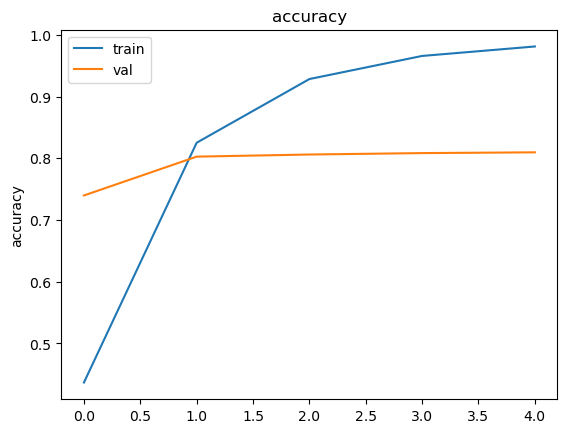

In [8]:
plot_results(epoch_results, 'accuracy')

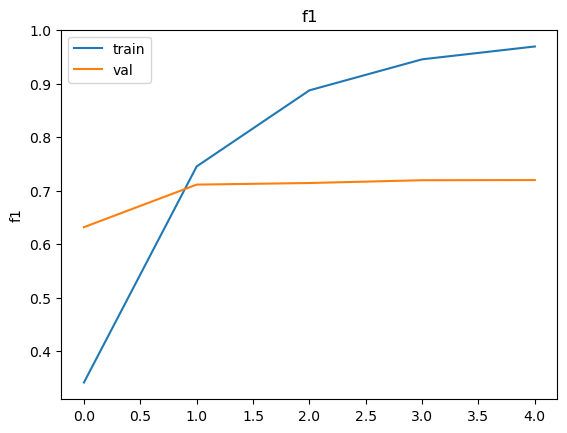

In [9]:
plot_results(epoch_results, 'f1')

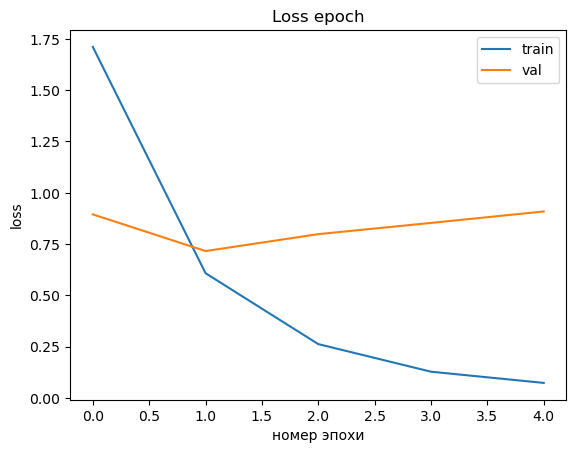

In [10]:
sns.lineplot(
    y = epoch_results['loss_train'],
    x = np.arange(len(epoch_results['loss_train'])),
    label = 'train'
)
sns.lineplot(
    y = epoch_results['loss_val'],
    x = np.arange(len(epoch_results['loss_val'])),
    label = 'val'
)
plt.xlabel('номер эпохи')
plt.ylabel('loss')
plt.title('Loss epoch')
plt.legend()

# model_2 (AdamW)

In [16]:
tokenizer = AutoTokenizer.from_pretrained("seara/rubert-tiny2-ru-go-emotions")
model = AutoModelForSequenceClassification.from_pretrained("seara/rubert-tiny2-ru-go-emotions")

config = model.config
config.num_labels = len(train['category'].unique())
model = AutoModelForSequenceClassification.from_config(config)


train_dataset = RuSportTopicsDataset(tokenizer, train)
val_dataset = RuSportTopicsDataset(tokenizer, val)

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 8,
    drop_last = True,
    shuffle = False
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = 8,
    drop_last = True,
    shuffle = False
)



optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00005)
loss_fn = nn.CrossEntropyLoss()

model, results =\
training_loop(
        # папка сохранения
        name_model_folder = 'model_2',
        # основные настройки
        epoches = 5,
        model = model,
        optimizer = optimizer,
        loss_fn = loss_fn,
        train_dataloader = train_dataloader,
        val_dataloader = val_dataloader,
        # regulizer
        regulizer_append = False,
        reg_type = None,
        # verbose
        verbose_epoch = 1
)

Расчетное время выполнения всего цикла 17.848 минут
Epoch     1/    5 || time: 214.179 || train loss: 1.679 || val_loss 0.883
Epoch     2/    5 || time: 143.811 || train loss: 0.596 || val_loss 0.724
Epoch     3/    5 || time: 143.843 || train loss: 0.257 || val_loss 0.782
Epoch     4/    5 || time: 142.868 || train loss: 0.126 || val_loss 0.910
Epoch     5/    5 || time: 144.412 || train loss: 0.078 || val_loss 0.966


In [21]:
epoch_data = create_epoch_data(results, 5)

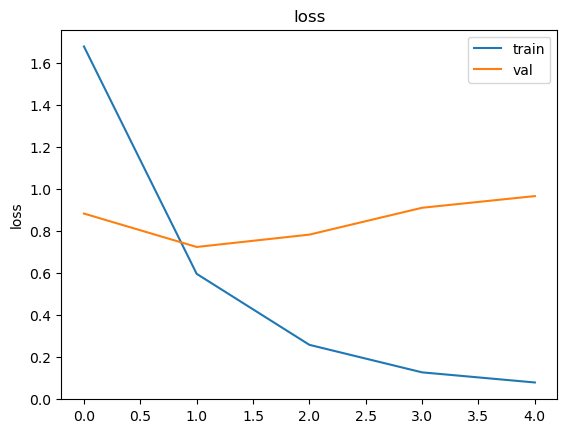

In [22]:
plot_results(epoch_data, 'loss')

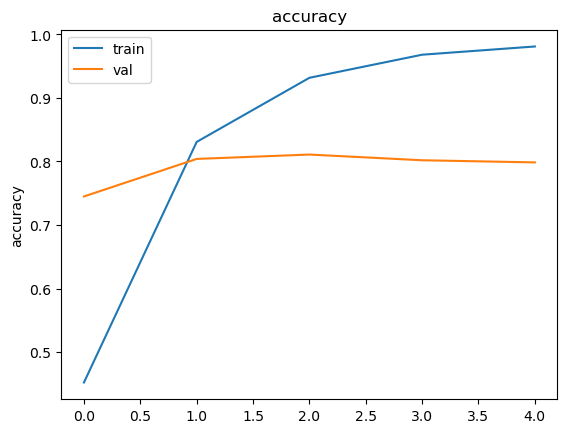

In [23]:
plot_results(epoch_data, 'accuracy')

# model_3

In [27]:
tokenizer = AutoTokenizer.from_pretrained("seara/rubert-tiny2-ru-go-emotions")
model = AutoModelForSequenceClassification.from_pretrained("seara/rubert-tiny2-ru-go-emotions")

config = model.config
config.num_labels = len(train['category'].unique())
model = AutoModelForSequenceClassification.from_config(config)


train_dataset = RuSportTopicsDataset(tokenizer, train)
val_dataset = RuSportTopicsDataset(tokenizer, val)

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 8,
    drop_last = True,
    shuffle = False
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = 8,
    drop_last = True,
    shuffle = False
)



optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00005)
loss_fn = nn.CrossEntropyLoss()

model, results =\
training_loop(
        # папка сохранения
        name_model_folder = 'model_3',
        # основные настройки
        epoches = 5,
        model = model,
        optimizer = optimizer,
        loss_fn = loss_fn,
        train_dataloader = train_dataloader,
        val_dataloader = val_dataloader,
        # regulizer
        regulizer_append = True,
        reg_type = 'l2',
        # verbose
        verbose_epoch = 1
)

Расчетное время выполнения всего цикла 14.025 минут
Epoch     1/    5 || time: 168.300 || train loss: 5.393 || val_loss 1.704
Epoch     2/    5 || time: 207.260 || train loss: 3.175 || val_loss 1.101
Epoch     3/    5 || time: 173.903 || train loss: 2.390 || val_loss 0.964
Epoch     4/    5 || time: 162.657 || train loss: 1.971 || val_loss 1.012
Epoch     5/    5 || time: 160.872 || train loss: 1.698 || val_loss 1.030


# Собственный токенизатор

In [29]:
import re

def cleaner(text_line):
    clean_text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ0-9\.\,\!\?\:\;\"\'\(\)\-\s]', '', text_line)
    clean_text = re.sub(r'[\n\r\t\\]', '', clean_text)
    clean_text = clean_text.lower().strip()
    return clean_text

In [31]:
from tokenizers.processors import TemplateProcessing

special_tokens=["[UNK]","[CLS]","[SEP]","[PAD]","[MASK]"]
temp_proc= TemplateProcessing(
    single="[CLS] $A [SEP]",
    pair="[CLS] $A [SEP] $B:1 [SEP]:1",
    special_tokens=[
            ("[CLS]", special_tokens.index("[CLS]")),
            ("[SEP]", special_tokens.index("[SEP]")),
            ],
)


from tokenizers import Tokenizer
from tokenizers.normalizers import (Sequence,Lowercase, NFD, StripAccents)
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.models import BPE
from tokenizers.decoders import BPEDecoder



tokenizer = Tokenizer(BPE())

tokenizer.normalizer = Sequence(
    [NFD(), # нормализация Unicode 
    Lowercase(), # нижний регистр
    StripAccents()]) # удаление акцентов

tokenizer.pre_tokenizer = Whitespace() # разбитие текста по пробелам
tokenizer.decoder = BPEDecoder() # Декодер
tokenizer.post_processor=temp_proc # добавление препроцессорных моментов (спец токены)


from tokenizers.trainers import BpeTrainer

trainer = BpeTrainer(
    vocab_size = 30000,
    special_tokens= special_tokens)

tokenizer.train_from_iterator(
    [cleaner(stroka) for stroka in train['text'].to_list()],
    trainer=trainer)
    
print(f"Trained vocab size: {tokenizer.get_vocab_size()}" )

Trained vocab size: 30000


In [32]:
tokenizer.encode('Привет, друг').ids

[1, 1255, 1945, 2]

In [33]:
tokenizer.save('tokenizer_custom/tokenizer.json')

In [34]:
from transformers import BertTokenizerFast


tokenizer = BertTokenizerFast.from_pretrained('tokenizer_custom')
tokenizer.add_special_tokens({
                        "eos_token": "[SEP]",
                        "bos_token": "[CLS]",
                        "unk_token": "[UNK]",
                        "pad_token": "[PAD]",
                        "mask_token": "[MASK]"
})

len(tokenizer.get_vocab())

file tokenizer_custom\config.json not found


30000

In [35]:
tokenizer.encode('Привет, друг')

[1, 1255, 1945, 2]

# Проверка работы нового токенизатора

In [ ]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
config = model.config
config.num_labels = len(train['category'].unique())
config.hidden_size = 312
config.num_attention_heads = 8
config.max_position_embedding = 512
config.max_position_embeddings = 512
config.num_hidden_layers = 4
config.emb_size = 512
model = AutoModelForSequenceClassification.from_config(config)




train_dataset = RuSportTopicsDataset(tokenizer, train)
val_dataset = RuSportTopicsDataset(tokenizer, val)

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    drop_last = True,
    shuffle = False
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = 32,
    drop_last = True,
    shuffle = False
)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.00005)
loss_fn = nn.CrossEntropyLoss().to(device)
model = model.to(device)

for epoch in range(1, 4):
            
        loss_train_summarize = 0.0
        loss_val_summarize = 0.0
        
        start_time = time.time()

        for batch in train_dataloader:
                
                model.train()
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask)[0]

                # Тренировочный потери
                loss = loss_fn(outputs, labels.long())
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # tepoch.set_postfix(loss = loss.item())
                
                loss_train_summarize += loss.item()

        print(loss_train_summarize / len(train_dataloader))

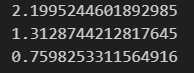

In [63]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
config = model.config
config.vocab_size = tokenizer.vocab_size
config.hidden_dim = 1024
config.num_labels = len(train['category'].unique())
config.hidden_size = 312
config.num_attention_heads = 8
config.max_position_embedding = 512
config.max_position_embeddings = 512
config.num_hidden_layers = 4
config.emb_size = 512
model = AutoModelForSequenceClassification.from_config(config)
tokenizer = BertTokenizerFast.from_pretrained('tokenizer_custom')
tokenizer.add_special_tokens({
                        "eos_token": "[SEP]",
                        "bos_token": "[CLS]",
                        "unk_token": "[UNK]",
                        "pad_token": "[PAD]",
                        "mask_token": "[MASK]"
})


train_dataset = RuSportTopicsDataset(tokenizer, train)
val_dataset = RuSportTopicsDataset(tokenizer, val)

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    drop_last = True,
    shuffle = False
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = 32,
    drop_last = True,
    shuffle = False
)


optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00005)
loss_fn = nn.CrossEntropyLoss()

model, results =\
training_loop(
        # папка сохранения
        name_model_folder = 'model_4',
        # основные настройки
        epoches = 5,
        model = model,
        optimizer = optimizer,
        loss_fn = loss_fn,
        train_dataloader = train_dataloader,
        val_dataloader = val_dataloader,
        # regulizer
        regulizer_append = False,
        reg_type = None,
        # verbose
        verbose_epoch = 1
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

Расчетное время выполнения всего цикла 49.348 минут
Epoch     1/    5 || time: 592.174 || train loss: 2.102 || val_loss 1.345
Epoch     2/    5 || time: 463.549 || train loss: 0.944 || val_loss 0.854
Epoch     3/    5 || time: 494.165 || train loss: 0.458 || val_loss 0.815
Epoch     4/    5 || time: 465.384 || train loss: 0.263 || val_loss 0.886
Epoch     5/    5 || time: 472.367 || train loss: 0.161 || val_loss 0.969


In [64]:
epoch_data = create_epoch_data(results, 5)

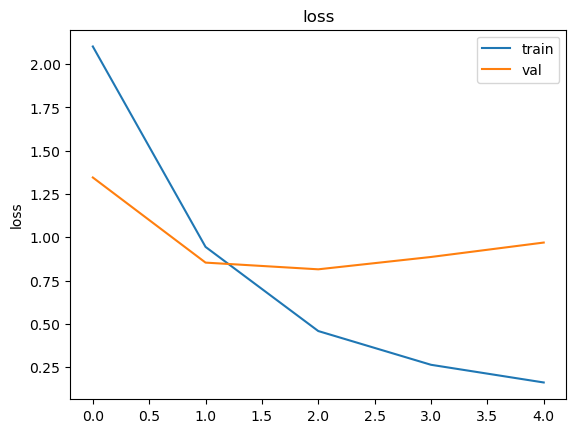

In [65]:
plot_results(epoch_data, 'loss')

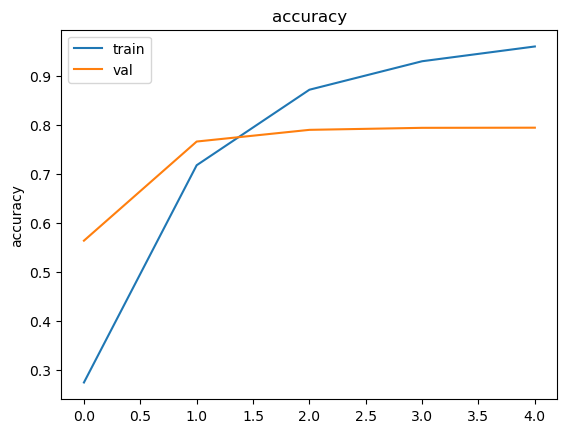

In [66]:
plot_results(epoch_data, 'accuracy')

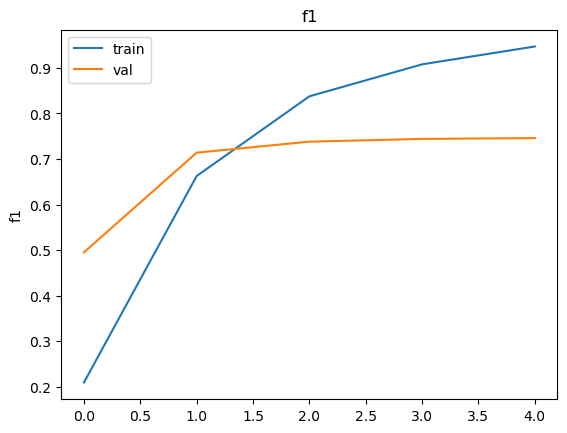

In [67]:
plot_results(epoch_data, 'f1')

# model_5

In [68]:
tokenizer = BertTokenizerFast.from_pretrained('tokenizer_custom')
tokenizer.add_special_tokens({
                        "eos_token": "[SEP]",
                        "bos_token": "[CLS]",
                        "unk_token": "[UNK]",
                        "pad_token": "[PAD]",
                        "mask_token": "[MASK]"
})
model = AutoModelForSequenceClassification.from_pretrained("seara/rubert-tiny2-ru-go-emotions")

config = model.config
config.num_labels = len(train['category'].unique())
config.vocab_size = tokenizer.vocab_size
'''config.hidden_size = 312
config.num_attention_heads = 8
config.max_position_embedding = 512
config.max_position_embeddings = 512
config.num_hidden_layers = 4
config.emb_size = 512'''
model = AutoModelForSequenceClassification.from_config(config)


train_dataset = RuSportTopicsDataset(tokenizer, train)
val_dataset = RuSportTopicsDataset(tokenizer, val)

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    drop_last = True,
    shuffle = False
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = 32,
    drop_last = True,
    shuffle = False
)


optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00005)
loss_fn = nn.CrossEntropyLoss()

model, results =\
training_loop(
        # папка сохранения
        name_model_folder = 'model_5',
        # основные настройки
        epoches = 5,
        model = model,
        optimizer = optimizer,
        loss_fn = loss_fn.to(device),
        train_dataloader = train_dataloader,
        val_dataloader = val_dataloader,
        # regulizer
        regulizer_append = False,
        reg_type = None,
        # verbose
        verbose_epoch = 1
)

file tokenizer_custom\config.json not found


Расчетное время выполнения всего цикла 131.016 минут
Epoch     1/    5 || time: 1572.195 || train loss: 2.160 || val_loss 1.382
Epoch     2/    5 || time: 1317.364 || train loss: 0.945 || val_loss 0.845
Epoch     3/    5 || time: 1493.131 || train loss: 0.463 || val_loss 0.811
Epoch     4/    5 || time: 1123.227 || train loss: 0.256 || val_loss 0.823
Epoch     5/    5 || time: 1558.951 || train loss: 0.155 || val_loss 0.954


In [70]:
epoch_data = create_epoch_data(results, 5)

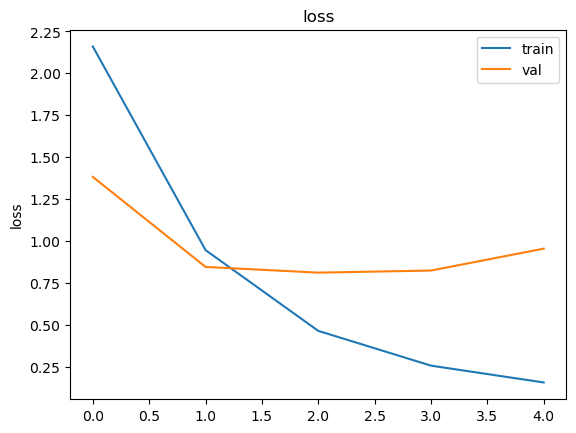

In [71]:
plot_results(epoch_data, 'loss')

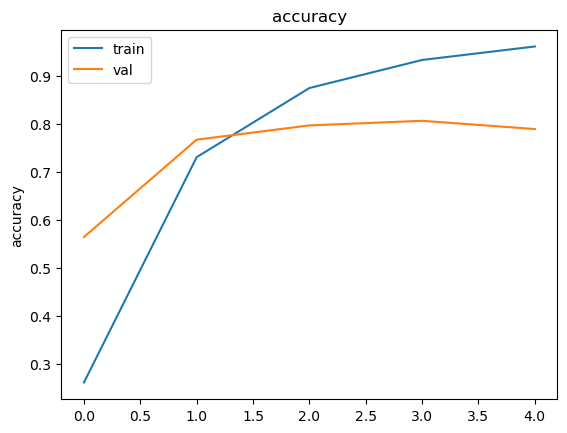

In [72]:
plot_results(epoch_data, 'accuracy')

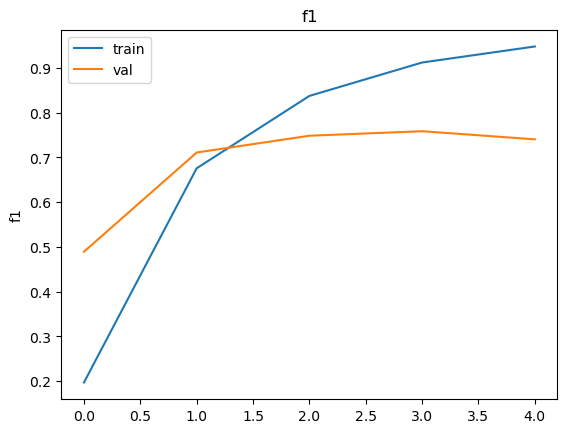

In [73]:
plot_results(epoch_data, 'f1')

# model_6

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('tokenizer_custom')
tokenizer.add_special_tokens({
                        "eos_token": "[SEP]",
                        "bos_token": "[CLS]",
                        "unk_token": "[UNK]",
                        "pad_token": "[PAD]",
                        "mask_token": "[MASK]"
})
model = AutoModelForSequenceClassification.from_pretrained("seara/rubert-tiny2-ru-go-emotions")

config = model.config
config.num_labels = len(train['category'].unique())
config.vocab_size = tokenizer.vocab_size
config.max_position_embeddings = 512
model = AutoModelForSequenceClassification.from_config(config)

train_dataset = RuSportTopicsDataset(tokenizer, train)
val_dataset = RuSportTopicsDataset(tokenizer, val)

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    drop_last = True,
    shuffle = False
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = 32,
    drop_last = True,
    shuffle = False
)


optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00005)
loss_fn = nn.CrossEntropyLoss()

model, results =\
training_loop(
        # папка сохранения
        name_model_folder = 'model_6',
        # основные настройки
        epoches = 5,
        model = model,
        optimizer = optimizer,
        loss_fn = loss_fn.to(device),
        train_dataloader = train_dataloader,
        val_dataloader = val_dataloader,
        # regulizer
        regulizer_append = False,
        reg_type = None,
        # verbose
        verbose_epoch = 1
)

# model_7

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("seara/rubert-tiny2-ru-go-emotions")
model = AutoModelForSequenceClassification.from_pretrained("seara/rubert-tiny2-ru-go-emotions")

config = model.config
config.num_labels = len(train['category'].unique())
model = AutoModelForSequenceClassification.from_config(config)

train_dataset = RuSportTopicsDataset(tokenizer, train)
val_dataset = RuSportTopicsDataset(tokenizer, val)

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    drop_last = True,
    shuffle = False
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = 32,
    drop_last = True,
    shuffle = False
)


optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00005)
loss_fn = nn.CrossEntropyLoss()

model, results =\
training_loop(
        # папка сохранения
        name_model_folder = 'model_7',
        # основные настройки
        epoches = 4,
        model = model,
        optimizer = optimizer,
        loss_fn = loss_fn.to(device),
        train_dataloader = train_dataloader,
        val_dataloader = val_dataloader,
        # regulizer
        regulizer_append = False,
        reg_type = None,
        # verbose
        verbose_epoch = 1
)

# model_8

- смена lr на 0.00001
- config.emb_size = 256
- config.hidden_size = 360

In [28]:
tokenizer = AutoTokenizer.from_pretrained("seara/rubert-tiny2-ru-go-emotions")
model = AutoModelForSequenceClassification.from_pretrained("seara/rubert-tiny2-ru-go-emotions")

config = model.config
config.num_labels = len(train['category'].unique())
config.emb_size = 256
config.hidden_size = 360
config.label2id = category2label
config.id2label = {str(key): value for key, value in label2category.items()}
model = AutoModelForSequenceClassification.from_config(config)



train_dataset = RuSportTopicsDataset(tokenizer, train)
val_dataset = RuSportTopicsDataset(tokenizer, val)

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    drop_last = True,
    shuffle = False
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = 32,
    drop_last = True,
    shuffle = False
)


optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)
loss_fn = nn.CrossEntropyLoss()

model, results =\
training_loop(
        # папка сохранения
        name_model_folder = 'model_8',
        # основные настройки
        epoches = 10,
        model = model,
        optimizer = optimizer,
        loss_fn = loss_fn.to(device),
        train_dataloader = train_dataloader,
        val_dataloader = val_dataloader,
        # regulizer
        regulizer_append = False,
        reg_type = None,
        # verbose
        verbose_epoch = 1
)

Расчетное время выполнения всего цикла 36.756 минут
Epoch     1/   10 || time: 220.537 || train loss: 2.563 || val_loss 2.552
Epoch     2/   10 || time: 117.403 || train loss: 2.489 || val_loss 2.301
Epoch     3/   10 || time: 114.059 || train loss: 1.935 || val_loss 1.573
Epoch     4/   10 || time: 114.760 || train loss: 1.363 || val_loss 1.178
Epoch     5/   10 || time: 114.412 || train loss: 0.987 || val_loss 0.990
Epoch     6/   10 || time: 114.354 || train loss: 0.755 || val_loss 0.896
Epoch     7/   10 || time: 114.180 || train loss: 0.592 || val_loss 0.843
Epoch     8/   10 || time: 115.689 || train loss: 0.467 || val_loss 0.823
Epoch     9/   10 || time: 114.122 || train loss: 0.373 || val_loss 0.816
Epoch    10/   10 || time: 114.113 || train loss: 0.299 || val_loss 0.818


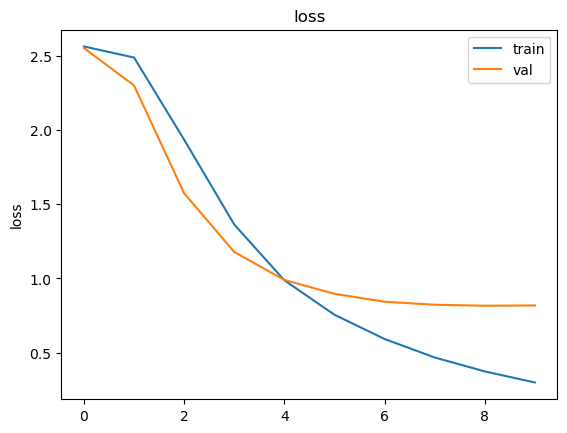

In [31]:
epoch_data = create_epoch_data(results, 10)
plot_results(epoch_data, 'loss')

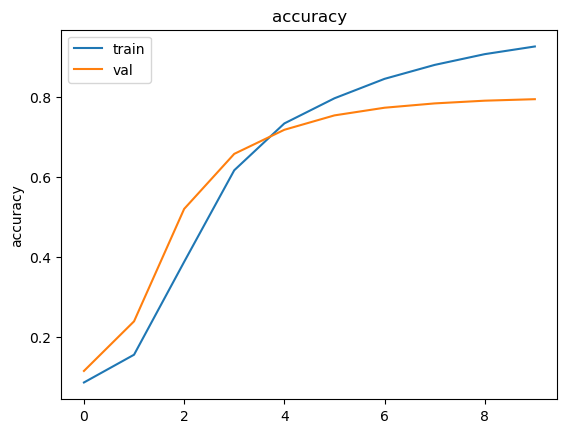

In [32]:
plot_results(epoch_data, 'accuracy')

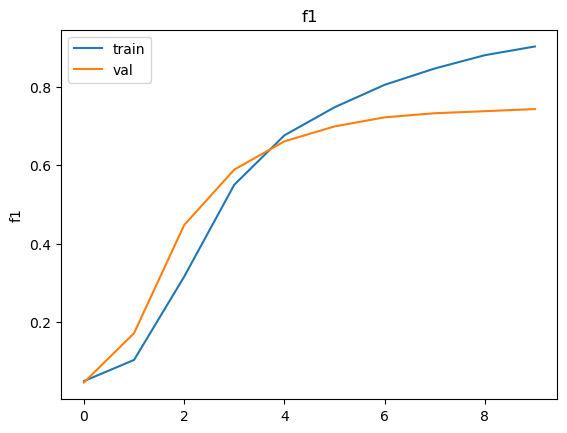

In [33]:
plot_results(epoch_data, 'f1')

# model_9

In [35]:
tokenizer = AutoTokenizer.from_pretrained("seara/rubert-tiny2-ru-go-emotions")
model = AutoModelForSequenceClassification.from_pretrained("seara/rubert-tiny2-ru-go-emotions")

config = model.config
config.num_labels = len(train['category'].unique())
config.emb_size = 512
config.hidden_size = 612
config.label2id = category2label
config.id2label = {str(key): value for key, value in label2category.items()}
model = AutoModelForSequenceClassification.from_config(config)



train_dataset = RuSportTopicsDataset(tokenizer, train)
val_dataset = RuSportTopicsDataset(tokenizer, val)

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    drop_last = True,
    shuffle = False
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = 32,
    drop_last = True,
    shuffle = False
)


optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00005)
loss_fn = nn.CrossEntropyLoss()

model, results =\
training_loop(
        # папка сохранения
        name_model_folder = 'model_9',
        # основные настройки
        epoches = 10,
        model = model,
        optimizer = optimizer,
        loss_fn = loss_fn.to(device),
        train_dataloader = train_dataloader,
        val_dataloader = val_dataloader,
        # regulizer
        regulizer_append = False,
        reg_type = None,
        # stop mode
        partience = 2,
        # verbose
        verbose_epoch = 1
)

Расчетное время выполнения всего цикла 25.782 минут
Epoch     1/   10 || time: 154.694 || train loss: 1.726 || val_loss 0.891
Epoch     2/   10 || time: 153.774 || train loss: 0.566 || val_loss 0.714
Epoch     3/   10 || time: 150.649 || train loss: 0.210 || val_loss 0.781
STOP MODE на 4 эпохе


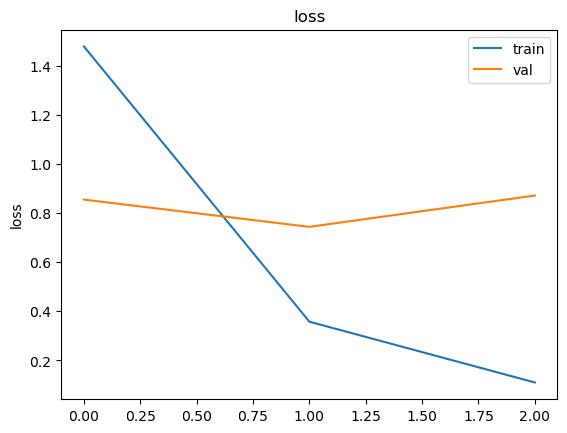

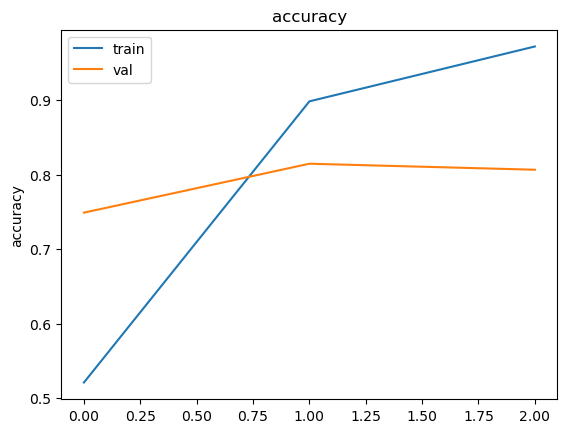

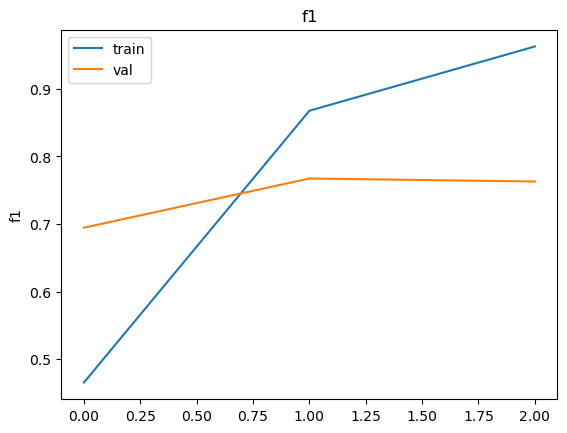

In [39]:
plotting(results, 3)

# Вывод

- большинство моделей выдает точность 0.8
- на уменьшение потерь сильно влияет скорость обучения (lr) (0.00005 оптимальная)